<a href="https://colab.research.google.com/github/srishti-git1110/Contrastive-PCA/blob/main/FFF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from numpy import array
from numpy import linalg as la
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import cluster
from math import pi
from math import sqrt

Some variable description - 

*n_components* = no of principal components

*n_alphas* = 40 (default) acc to paper no of potential alphas to be tested

*max_log_alpha* = 3 (default) acc to paper 40 equally spaces values of alphas between 10^-1 and 10^max_log_alpha

*active_labels* = classes/clusters/sources of variation of interest

In [ ]:
#some synthetic data
N = 400
D = 30

#background
B = np.zeros((N, D))
B[:,0:10] = np.random.normal(0.5,11,(N,10))
B[:,10:20] = np.random.normal(0.5,3,(N,10))
B[:,20:30] = np.random.normal(0.5,1,(N,10))


#target
A = np.zeros((N, D))
A[:,0:10] = np.random.normal(0.5,11,(N,10))

A[0:100, 10:20] = np.random.normal(0.5,1,(100,10))
A[0:100, 20:30] = np.random.normal(0.5,1,(100,10))

A[100:200, 10:20] = np.random.normal(0.5,1,(100,10))
A[100:200, 20:30] = np.random.normal(3.5,1,(100,10))

A[200:300, 10:20] = np.random.normal(7,1,(100,10))
A[200:300, 20:30] = np.random.normal(0.5,1,(100,10))

A[300:400, 10:20] = np.random.normal(7,1,(100,10))
A[300:400, 20:30] = np.random.normal(3.5,1,(100,10))


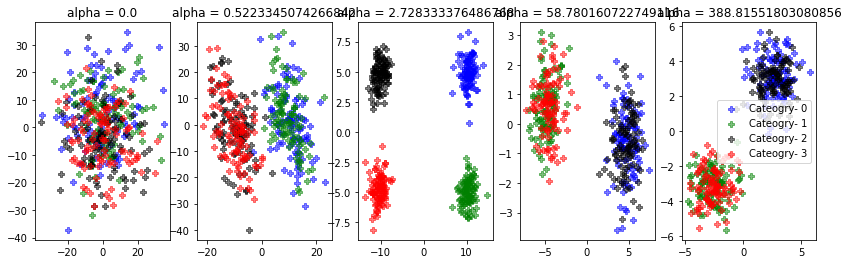

In [ ]:
class C_PCA(object):
    
    def __init__(self, standardize = False, n_components = 2):
        self.standardize = standardize
        self.n_components = n_components
    
    
    def standardize_array(self, array):
        #standardize 'array' in the range 0-1
        standardized_array =  (array - np.nanmean(array, axis=0)) / np.std(array, axis=0)
        return np.nan_to_num(standardized_array)
    
    
    def transform(self, dataset, plot=True, n_alphas=40, alpha_selection='auto', max_log_alpha=3, n_alphas_to_return=5, active_labels=None, colors=None, legend=None, alpha_value=None):
        
        #checking parameter compatibilty
        if (plot==True and not(self.n_components==2)):
            raise ValueError("Cannot show higher than 2D plots")
        if not(alpha_selection=='auto' or alpha_selection=='manual' or alpha_selection=='all'):
            raise ValueError("Invalid value for parameter alpha_selection - should be either of 'auto' , 'manual' or 'all'")
        if (alpha_selection=='all' and plot==True):
            raise ValueError("Plot cannot be True if alpha selection is all: either select another value for alpha_selection or set plot to false")
        if (alpha_value==None and alpha_selection=='manual'):
            raise ValueError("alpha_value missing in function call")
        if colors is None:
                 self.colors = ['b','g','k','r'] #4 colors == atmost 4 labels shall be visually distingushable; used in plotting 

        if plot:
            if active_labels is None:
                active_labels = np.ones(dataset.shape[0])
            self.active_labels = active_labels
            
            if (alpha_selection == 'auto'):
                transformed_data, best_alphas = self.auto_cpca(dataset, n_alphas, max_log_alpha, n_alphas_to_return) #performs spectral clustering on affinity matrix + cPCA to return
                                                                                                                   #a list of alphas and corresponding data projected to cPCs 
                plt.figure(figsize=[14,4])
                for j, data in enumerate(transformed_data):
                    data = np.array(data)
                    plt.subplot(1,5,j+1)
                    unique_labels = np.sort(np.unique(self.active_labels))
                    for i, label in enumerate(unique_labels):
                        voi = np.where(self.active_labels == label)
                        plt.scatter(data[voi,0], data[voi,1], color=self.colors[i], marker='P', alpha=0.5, label='Cateogry- '+str(label))
                        
                    plt.title('alpha = ' +str(best_alphas[j]))
                if (len(unique_labels) > 1):
                    plt.legend()
                plt.show()
                
            elif (alpha_selection == 'manual'):
                data = self.cpca_alpha(dataset=dataset, alpha=alpha_value)
                data = np.array(data)
                plt.figure(figsize=[5,5])
                for i, label in enumerate(np.sort(np.unique(self.active_labels))):
                  voi = np.where(self.active_labels==label)
                  plt.scatter(data[voi,0], data[voi,1], color=self.colors[i], alpha=0.5, label='Class '+str(i))
                plt.title('alpha = '+str(alpha_value))
                if len(np.unique(self.active_labels))>1:
                    plt.legend()
                plt.show()
                

            return
        
        #following else gets executed if plots aren't displayed, plot = False
        else:
            if (alpha_selection == 'auto'):
                transformed_data, best_alphas = self.auto_cpca(dataset, n_alphas, max_log_alpha, n_alphas_to_return)
                alphas = best_alphas
            elif (alpha_selection == 'all'):
                transformed_data, all_alphas = self.all_cpca(dataset, n_alphas, max_log_alpha)
                alphas = all_alphas
            else:
                transformed_data = self.cpca_alpha(dataset, alpha_value)
                alphas = alpha_value
        return transformed_data, alphas
                
        
    def fit(self, target_set, background_set, preprocess_by_pca_ndim = None):
        self.affinity_matrix = None

        # Datasets and sizes
        self.tg = target_set
        self.bg = background_set
        self.n_tg, self.dim_tg = target_set.shape
        self.n_bg, self.dim_bg = background_set.shape

        if not(self.dim_tg == self.dim_bg):
            raise ValueError("Target and background datasets are of unequal dimensionality/number of features.")

        #Centering & standardizing both datasets
        self.tg = self.tg - np.nanmean(self.tg, axis=0)
        if self.standardize:
            self.tg = self.standardize_array(self.tg)
            
        self.bg = self.bg - np.nanmean(self.bg, axis=0)
        if self.standardize:
            self.bg = self.standardize_array(self.bg)
            
        #if original dimensionality is higher than 1000 or value provided by user, PCA is used on concatenated tg+bg to reduce the dimensionality to
        #1000 or value provided by user
        
        if preprocess_by_pca_ndim is None:
            preprocess_by_pca_ndim = 1000

        if (self.dim_bg > preprocess_by_pca_ndim):
            data = np.concatenate((self.tg, self.bg), axis=0)
            pca = PCA(n_components = preprocess_by_pca_ndim) 
            data = pca.fit_transform(data)
            
            #separating datasets after std. PCA
            self.tg = data[:self.n_tg,:]
            self.bg = data[self.n_tg:,:]
            self.dim_tg = preprocess_by_pca_ndim

        
        #covariance matrices of centered data
        self.tg_cov = self.tg.T.dot(self.tg) / (self.n_tg - 1)
        self.bg_cov = self.bg.T.dot(self.bg) / (self.n_bg - 1)
        

        
    def cpca_alpha(self, dataset, alpha=1):
        n_components = self.n_components
        optimise = self.tg_cov - alpha*self.bg_cov
        optimise = optimise.astype('float64')
                      
        try:
            w, v = la.eig(optimise)             #v-matrix of evec, cols are vectors; w isn't sorted
        except np.linalg.LinAlgError:
            print("The eigenvalue computation does not converge.")
                      
        
        eig_ = np.argpartition(w, -n_components)[-n_components:]
        eig_ = eig_[np.argsort(-w[eig_])]
        top_vect = v[:, eig_]
        
        reduced_set = dataset.dot(top_vect)
        reduced_set[:,0] = reduced_set[:,0]*np.sign(reduced_set[0,0])
        reduced_set[:,1] = reduced_set[:,1]*np.sign(reduced_set[0,1])
        return reduced_set
    
    
                      
    def auto_cpca(self, dataset, n_alphas, max_log_alpha, n_alphas_to_return):
        best_alphas, all_alphas, _, _ = self.find_spectral_alphas(max_log_alpha, n_alphas, n_alphas_to_return)
        best_alphas = np.concatenate(([0], best_alphas)) 
        data_to_plot = []
        for alpha in best_alphas: 
            data_to_plot.append(self.cpca_alpha(dataset=dataset, alpha=alpha))
        return data_to_plot, best_alphas

        
                      
    def find_spectral_alphas(self, max_log_alpha, n_alphas, n_alphas_to_return):
        self.create_affinity_matrix(max_log_alpha, n_alphas)
        affinity = self.affinity_matrix
        spectral = cluster.SpectralClustering(affinity = 'precomputed', n_clusters = n_alphas_to_return)
        alphas = list(np.concatenate(([0],np.logspace(-1, max_log_alpha, n_alphas))))
        
        spectral.fit(affinity)
        spec_labels = spectral.labels_
        best_alphas = []
        for i in range(n_alphas_to_return):
            
            lst = np.where(spec_labels == i)[0]
            if not(0 in lst): #we manually include alpha=0 for PCA in auto_cpca, exclude here
                submatrix = affinity[lst][:, lst]
                aff_sum = np.nansum(submatrix, axis=0)
                l = lst[np.argmax(aff_sum)]
                best_alphas = best_alphas + [alphas[l]]
                
        return np.sort(best_alphas), alphas, affinity[0,:], spec_labels
                      
                      
    def create_affinity_matrix(self, max_log_alpha, n_alphas):
        alphas = np.concatenate(([0], np.logspace(start=-1, stop=max_log_alpha, num=n_alphas))) #alpha=0 included to compare with std. PCA
        subspaces = list()
        k = len(alphas)
        affinity = 0.5*np.identity(k)
        for alpha in alphas:
            space = self.cpca_alpha(dataset=self.tg, alpha=alpha) #stores reduced set for a particular alpha
            q, r = la.qr(space) #QR decompose - Q orthonormal matrix R upper triang matrix
            subspaces.append(q)
        
        for i in range(k):
            for j in range(i+1, k):
                q0 = subspaces[i]
                q1 = subspaces[j]
                u, s, v = np.linalg.svd(q0.T.dot(q1)) #singular value decomposition
                affinity[i,j] = s[0]*s[1]
                      
        affinity = affinity + affinity.T
        self.affinity_matrix = np.nan_to_num(affinity)
        

                      
    def fit_transform(self, target, background, plot=False, alpha_selection='auto', n_alphas=40,  max_log_alpha=3, n_alphas_to_return=5, active_labels = None, colors=None, legend=None, alpha_value=None, return_alphas=False):
        self.fit(target, background)
        return self.transform(dataset=self.tg, alpha_selection=alpha_selection, n_alphas=n_alphas, max_log_alpha=max_log_alpha, n_alphas_to_return=n_alphas_to_return, plot=plot, active_labels=active_labels, colors=colors, legend=legend, alpha_value=alpha_value)         
    
                      
    #methods to return c_pca object attributes ()
    def get_bg_data(self):
        return self.bg
    def get_tg_data(self):
        return self.tg
    def get_affinity_matrix(self):
        return self.affinity_matrix
    def get_active_labels(self):
        return self.active_labels
    

obj1 = C_PCA()
active_labels = []
for i in range(100):
  active_labels.append(0)
for i in range(100):
  active_labels.append(1)
for i in range(100):
  active_labels.append(2)
for i in range(100):
  active_labels.append(3)

obj1.fit_transform(target=A, background=B, plot=True, active_labels=np.array(active_labels)) #, alpha_selection='manual', alpha_value=0.0)

With alpha=0.0, cPCA reduces to standard PCA.

We, hence see that PCA wasn't able to capture the variance between different cateogries, as the first 10 dimensions in target data are significantly larger in variance than the rest; and so PCs are selected from these thus making no difference between subgroups.

With small alphas (alpha=0.52233 here), these first 10 features get cancelled by background data (as they are high in variance in the background data as well), and cPCA is able to distinguish green/blue from red/black as it now selects from middle 10 features as these are lesser in variance (in background) than the first 10. Also, middle 10 features are fairly variable in target data.

It is of interest to note that the last 10 features are even lesser in variance (in background) as compared to middle 10, but cPCA doesn't select from these ones for mildly higher (than 0) values of alpha. But as we go on to penalise more by increasing alpha, even lesser variance from background would be required and these shall come into the picture.



With an intermediate value of alpha (middle scatter plot), cPCA is able to cluster all four cateogries as now it is now selects from last 20 features.
It could be because the last 20 features taken together are highly variable in target data while they aren't a lot in background data. this is the sweet spot of the tradeoff.

With even higher alphas, those features shall be chosen from, that have the least variance in background data (i.e. last 10), and so we are able to distinguish between red-green and black-blue. Here the algo cares more about selecting features with very small variance in background data as compared to caring about selecting features with high variance in target data, hence the observed behaviour) 

(It should be clear from the way artifical data is generated that why last 10 are good to cluster red-green from black-blue and the same for middle 10. In the artifical data first 100 points are blue cateogry, next 100 green, next 100 black and last 100 red, also clear from the legend in plots.
Middle 10 features have the same distribution for green and blue which is different from the common distribution for red and black.
Similarly, last 10 have the same distribution for blue black which is different from the common distribution for red and green.)






**Write up: Discuss what kind of dataset it would make sense to use Contrastive PCA on.**

*Intro:*

Information of interest lies in variability - The basic assumption/principle Standard PCA is based on. PCA exploits this assumption that the most interesting (i.e. informative) directions of any data are the ones along which the data varies the most.  

  
   


*When does PCA fails to prove useful?* 

However, there might be cases when the most variable directions aren’t of prime interest to the analyst; and rather some other directions with less dominant variance across the dataset are. In other words, due to the nature of the data source or data collection or any other reasons, there might be some inherent but uninteresting variation present in the data that might dominate over the interesting source of variation.
   
     
      

*Why not PCA?*

In such (and similar) cases, PCA shall fail to provide the best projections as desired by the analyst as it would choose those directions to project the data along which the data varies the most across the space & that corresponds to the most dominant source of variance.  
   
    


*How to use cPCA to mitigate this?*

The key here is to use a background data carrying the same or similar type of universal variation as the target data but free from the variability that needs to be analysed/that’s of interest. 
This way the background data can be used to cancel out the universal variation in the target data so that the (contrastive) Principal components shall now represent the variability stemming from our source of interest and that is unique to the target data. cPCA captures those components that are high in vaqriance in the target data but low in variance in the background data i.e. information exclusive to target data.


   


*Summary:*

In short, while PCA brings out the most interesting directions in a single dataset, cPCA brings out ‘the most interesting differences across datasets’.

Target data = confounders + interesting source of variation
Background data = All known confounders matched with target data

(confounders = uninteresting/undesired sources of variation)
  


*Examples/Use cases:*

**Treatment control settings -** In an experiment to test the difference in effects of various types of fertiliser treatments on crops (assuming the experimental conditions eg. humidity, temperature, concentration of treatments etc. remain same throughout), the features in the target set, which is the crops subjected to treatment are subjected to two sources of variation - inherent variation in crops (breed etc) and variation due to treatments.

If in case, the variation between crops is dominant, then the first few components by standard PCA shall represent a notion of features good enough to classify types of crops rather than types of treatments. (This is just to explain in other words; this shouldn't imply that PCs shall give a good accuracy score if used as features in a supervised classification algo)

Here a control set - crops subjected to no treatment - shall also contain the inherent variability in crops and could be used to cancel out this variation & hence to project the data in such dimensions that are capable of differentiating between different classes of treatments. 

  
   

**Subgroups in a Population -** We might want to project our data onto such dimensions that are capable of clustering (or classifying) subgroups within a heterogeneous population. But, it might occur that the intra-group variation is dominant over the inter-group variation in which PCA shall be inclined towards the former.

cPCA with the background data as one of the groups can be used to cancel out intra-group variation and thus obtain dimensions that are useful as axes to cluster different groups.
 

  

**Effect of a single medicine across subjects -** If subjects with different demographic profiles are given a medicine, one might be interested in exploring different ways the same medicine reacts on different subjects. Here there are two sources of variability in the treatment group - variation due to demography and variation due to different effects of medicine.
 A control group representing similar demographic profiles in subjects can be used to eliminate this source of variation from the target data.
  



**Change in experimental conditions** - An exactly same treatment can react differently on a single subject under different experimental conditions; this is called variation due to noise that we want to avoid. In order to capture only the signal variation, we can observe the subjects under different experimental conditions as the control data to cancel out the noisy variation in the target data.

 

**Changes in structure of variation over time -** In any experiment setup, we might want to investigate changes in variance structure over time. At time t we might want to visualise data on those projections that have undergone change in variance structure from anytime before, say t - k. We can use the data from time t-k to cancel out the variation that’s persistent from the past & that can help us with any new type of variation that might have been introduced in the setup over time.


